# Object Segmentation AI Model

## DATA PREPARATION

### Data Cleaning

In [119]:
import os
import shutil
import json
import cv2
import numpy as np
import shutil
from collections import defaultdict
from PIL import Image

In [120]:
from cityscapesscripts.helpers.labels import labels

In [121]:
dataset_dir = './cityscapes'
cityscapes_image_dir = './cityscapes/leftimg8bit'
cityscapes_anno_dir = './cityscapes/gtFine'
train_image_dir = './cityscapes/images/train'
train_anno_dir = './cityscapes/masks/train'
val_image_dir = './cityscapes/images/val'
val_anno_dir = './cityscapes/masks/val'
test_image_dir = './cityscapes/images/test'
test_anno_dir = './cityscapes/masks/test'

In [122]:
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_anno_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_anno_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_anno_dir, exist_ok=True)

In [123]:
def json_to_mask(json_file, class_name_to_trainid):
    with open(json_file) as f:
        data = json.load(f)
    mask = np.zeros((data['imgHeight'], data['imgWidth']), dtype=np.uint8)
    for obj in data['objects']:
        polygon = np.array([obj['polygon']], dtype=np.int32)
        train_id = class_name_to_trainid.get(obj['label'], -1)  # Use -1 for undefined labels
        if train_id not in [-1, 255]:  # Only fill polygons with valid train_id
            cv2.fillPoly(mask, [polygon], color=train_id)
    return mask

def convert_polygon_to_bbox(polygon):
    x_coords = [point[0] for point in polygon]
    y_coords = [point[1] for point in polygon]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    width = x_max - x_min
    height = y_max - y_min
    return [x_min, y_min, width, height]

def process_and_convert(cityscapes_image_dir, cityscapes_anno_dir, output_dir):
    splits = ['train', 'val', 'test']
    class_name_to_trainid = {label.name: label.trainId for label in labels}

    for split in splits:
        dataset = {
            "images": [],
            "annotations": [],
            "categories": []
        }
        annotation_id = 1

        split_image_path = os.path.join(cityscapes_image_dir, split)
        split_annotation_path = os.path.join(cityscapes_anno_dir, split)
        
        for city in os.listdir(split_image_path):
            city_image_path = os.path.join(split_image_path, city)
            city_annotation_path = os.path.join(split_annotation_path, city)
            
            for img_file in os.listdir(city_image_path):
                if img_file.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(city_image_path, img_file)
                    annotation_file = img_file.replace('_leftImg8bit.png', '_gtFine_polygons.json')
                    annotation_path = os.path.join(city_annotation_path, annotation_file)
                    
                    # Copy image to corresponding split directory
                    output_img_path = os.path.join(output_dir, 'images', split, img_file)
                    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)
                    shutil.copy(img_path, output_img_path)
                    
                    img_id = img_file.split('_leftImg8bit')[0]
                    img_info = {
                        "file_name": os.path.relpath(output_img_path, os.path.join(output_dir, 'images')),
                        "height": cv2.imread(img_path).shape[0],
                        "width": cv2.imread(img_path).shape[1],
                        "id": img_id
                    }
                    dataset["images"].append(img_info)

                    # Create and save mask to corresponding split directory
                    if os.path.exists(annotation_path):
                        mask = json_to_mask(annotation_path, class_name_to_trainid)
                        output_mask_path = os.path.join(output_dir, 'masks', split, img_file.replace('_leftImg8bit.png', '_mask.png'))
                        os.makedirs(os.path.dirname(output_mask_path), exist_ok=True)
                        cv2.imwrite(output_mask_path, mask)

                        with open(annotation_path, "r") as f:
                            ann_data = json.load(f)
                        
                        for obj in ann_data["objects"]:
                            polygon = obj["polygon"]
                            label = obj["label"]
                            if label not in class_name_to_trainid:
                                continue
                            category_id = class_name_to_trainid[label]
                            if category_id in [255, -1]:  # Skip unlabeled and unknown categories
                                continue
                            bbox = convert_polygon_to_bbox(polygon)
                            if bbox[2] > 0 and bbox[3] > 0:  # Ensure bbox has positive width and height
                                annotation = {
                                    "segmentation": [polygon],
                                    "area": bbox[2] * bbox[3],  # area is width * height
                                    "iscrowd": 0,
                                    "image_id": img_id,
                                    "bbox": bbox,
                                    "category_id": category_id,
                                    "id": annotation_id
                                }
                                dataset["annotations"].append(annotation)
                                annotation_id += 1

        for label in labels:
            if label.trainId in [255, -1]:
                continue
            dataset["categories"].append({
                "supercategory": label.category,
                "id": label.trainId,
                "name": label.name
            })

        output_json_file = os.path.join(output_dir, f"{split}.json")
        with open(output_json_file, "w") as f:
            json.dump(dataset, f)

In [124]:
process_and_convert(cityscapes_image_dir, cityscapes_anno_dir, dataset_dir)

### Hyperparameter Setting

In [5]:
from tensorflow.keras.optimizers import Adam

In [129]:
learning_rate = 0.0001
batch_size = 8
optimizer = Adam(learning_rate=learning_rate)

### Dataset Creation

In [ ]:
import os
import json
from cityscapesscripts.helpers.labels import labels, name2label

def convert_cityscapes_to_coco(image_dir, annotation_dir, output_dir):
    for split in splits:
        dataset = {
            "images": [],
            "annotations": [],
            "categories": []
        }
        annotation_id = 1
        img_dir = os.path.join(image_dir, split)
        ann_dir = os.path.join(annotation_dir, split)

        for city in os.listdir(img_dir):
            img_city_dir = os.path.join(img_dir, city)
            ann_city_dir = os.path.join(ann_dir, city)

            for img_file in os.listdir(img_city_dir):
                if img_file.endswith("_leftImg8bit.png"):
                    img_id = img_file.split("_leftImg8bit")[0]
                    img_path = os.path.join(img_city_dir, img_file)
                    ann_file = img_file.replace("_leftImg8bit.png", "_gtFine_polygons.json")
                    ann_path = os.path.join(ann_city_dir, ann_file)

                    with open(ann_path, "r") as f:
                        ann_data = json.load(f)

                    img_info = {
                        "file_name": os.path.relpath(img_path, image_dir),
                        "height": ann_data["imgHeight"],
                        "width": ann_data["imgWidth"],
                        "id": img_id
                    }
                    dataset["images"].append(img_info)

                    for obj in ann_data["objects"]:
                        polygon = obj["polygon"]
                        label = obj["label"]
                        if label not in class_name_to_trainid:
                            continue
                        category_id = class_name_to_trainid[label]

                        annotation = {
                            "segmentation": [polygon],
                            "area": 0,
                            "iscrowd": 0,
                            "image_id": img_id,
                            "bbox": [],  # Bounding box will be auto-calculated by Detectron2
                            "category_id": category_id,
                            "id": annotation_id
                        }
                        dataset["annotations"].append(annotation)
                        annotation_id += 1

        for label in labels:
            if label.trainId == 255 or label.trainId == -1:
                continue
            dataset["categories"].append({
                "supercategory": label.category,
                "id": label.trainId,
                "name": label.name
            })

        output_file = os.path.join(output_dir, f"cityscapes_{split}_coco_format.json")
        with open(output_file, "w") as f:
            json.dump(dataset, f)

if __name__ == "__main__":
    image_dir = "path_to_cityscapes/leftImg8bit"
    annotation_dir = "path_to_cityscapes/gtFine"
    output_dir = "path_to_output"
    os.makedirs(output_dir, exist_ok=True)
    convert_cityscapes_to_coco(image_dir, annotation_dir, output_dir)


In [6]:
import tensorflow as tf
import torch
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [132]:
def get_num_classes(mask_dir):
    unique_classes = set()
    for mask_name in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_name)
        mask = load_img(mask_path, color_mode="grayscale")
        mask = img_to_array(mask).astype('int')  # Ensure mask is integer type
        unique_classes.update(np.unique(mask))  # Add unique values to the set
    return len(unique_classes), unique_classes

num_classes, unique_classes = get_num_classes(train_anno_dir)
print(f"Number of classes: {num_classes}")
print(f"Unique classes: {unique_classes}")

Number of classes: 12
Unique classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [133]:
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        img = load_img(img_path)
        mask = load_img(mask_path, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        mask = img_to_array(mask).astype('int')

        img = tf.image.resize_with_crop_or_pad(img, 512, 512)
        mask = tf.image.resize_with_crop_or_pad(mask, 512, 512)

        mask = tf.one_hot(mask, num_classes)
        mask = tf.reshape(mask, (512, 512, num_classes))
        images.append(img)
        masks.append(mask)
        
    return np.array(images), np.array(masks)

def create_augmented_dataset(images, masks, batch_size=4):
    def augment(image, mask):        
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_images, train_masks = load_data(train_image_dir, train_anno_dir)
val_images, val_masks = load_data(val_image_dir, val_anno_dir)
test_images, test_masks = load_data(test_image_dir, test_anno_dir)

train_dataset = create_augmented_dataset(train_images,train_masks, batch_size)
val_dataset = create_augmented_dataset(val_images,val_masks, batch_size)
test_dataset = create_augmented_dataset(test_images, test_masks, batch_size)

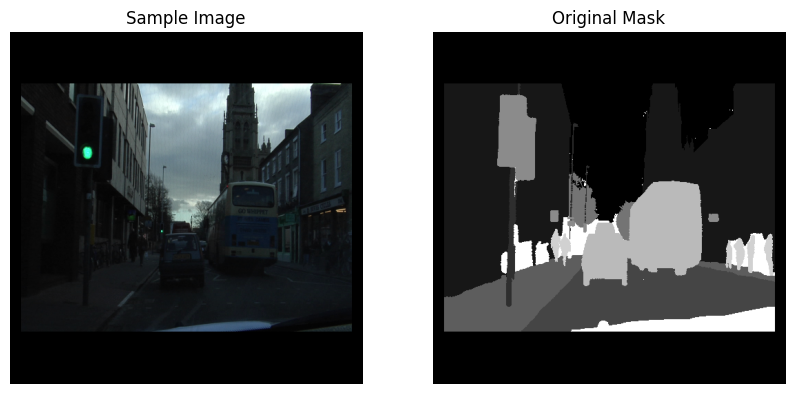

In [134]:
import matplotlib.pyplot as plt

# Select a sample image and mask
sample_image = train_images[0]
sample_mask = train_masks[0]

# Convert the one-hot encoded mask back to the original class index representation
original_mask = tf.argmax(sample_mask, axis=-1)

# Plot the sample image and the original mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Sample Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(original_mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.show()


## Model 1 : U-net

In [135]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import tensorflow as tf

In [136]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7), axis=0)
    return iou
    
def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + 1e-7) / (tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) + 1e-7), axis=0)
    return dice


In [137]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape=(512, 512, 3), num_classes=12):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder: Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = unet_model()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[iou_metric,dice_coefficient])
unet.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)   │ (None, 512, 512, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_589 (Conv2D)           │ (None, 512, 512, 64)      │           1,792 │ input_layer_41[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_590 (Conv2D)           │ (None, 512, 512, 64)      │          36,928 │ conv2d_589[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_164             │ (None, 256, 256, 64)      │               0 │ conv2d_590[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_591 (Conv2D)           │ (None, 256, 256, 128)     │          73,856 │ max_pooling2d_164[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_592 (Conv2D)           │ (None, 256, 256, 128)     │         147,584 │ conv2d_591[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_165             │ (None, 128, 128, 128)     │               0 │ conv2d_592[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_593 (Conv2D)           │ (None, 128, 128, 256)     │         295,168 │ max_pooling2d_165[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_594 (Conv2D)           │ (None, 128, 128, 256)     │         590,080 │ conv2d_593[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_166             │ (None, 64, 64, 256)       │               0 │ conv2d_594[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_595 (Conv2D)           │ (None, 64, 64, 512)       │       1,180,160 │ max_pooling2d_166[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_596 (Conv2D)           │ (None, 64, 64, 512)       │       2,359,808 │ conv2d_595[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_167             │ (None, 32, 32, 512)       │               0 │ conv2d_596[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_597 (Conv2D)           │ (None, 32, 32, 1024)      │       4,719,616 │ max_pooling2d_167[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_598 (Conv2D)           │ (None, 32, 32, 1024)      │       9,438,208 │ conv2d_597[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 31,032,460 (118.38 MB)

 Trainable params: 31,032,460 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 238s 20s/step - dice_coefficient: 0.6634 - iou_metric: 0.4999 - loss: 0.7914 - val_dice_coefficient: 0.6515 - val_iou_metric: 0.4861 - val_loss: 0.8057
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 231s 20s/step - dice_coefficient: 0.6597 - iou_metric: 0.4965 - loss: 0.7810 - val_dice_coefficient: 0.6885 - val_iou_metric: 0.5290 - val_loss: 0.7541
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 234s 20s/step - dice_coefficient: 0.6875 - iou_metric: 0.5286 - loss: 0.7304 - val_dice_coefficient: 0.7056 - val_iou_metric: 0.5478 - val_loss: 0.7062
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 235s 20s/step - dice_coefficient: 0.7091 - iou_metric: 0.5533 - loss: 0.6875 - val_dice_coefficient: 0.6966 - val_iou_metric: 0.5370 - val_loss: 0.6872
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 234s 20s/step - dice_coefficient: 0.6972 - iou_metric: 0.5390 - loss: 0.6758 - val_dice_coefficient: 0.7079 - val_iou_metric: 0.5509 - val_loss: 0.6822
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 236s 20s/ste

In [151]:
model.save_weights('./dataset/model/unet8.weights.h5')
model.save('./dataset/model/unet8_v1.h5')

13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


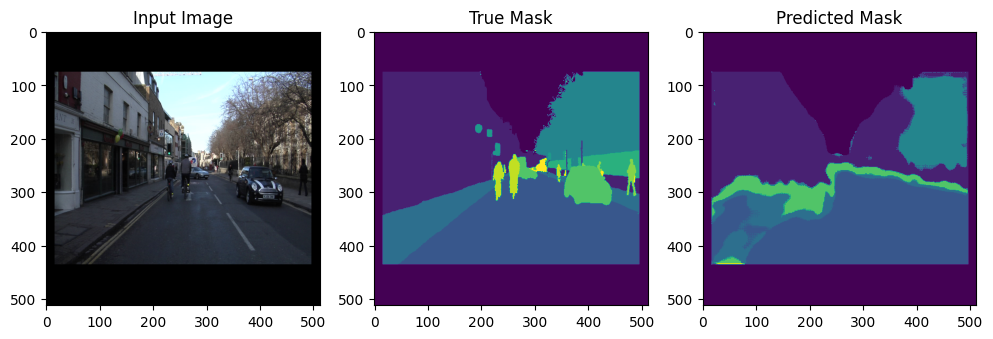

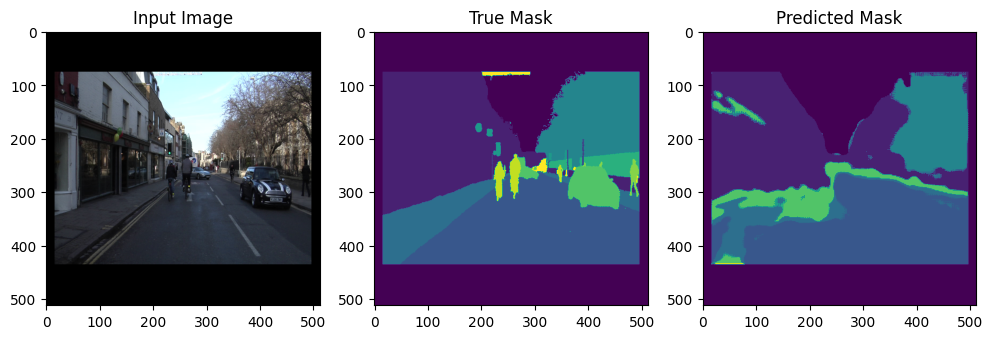

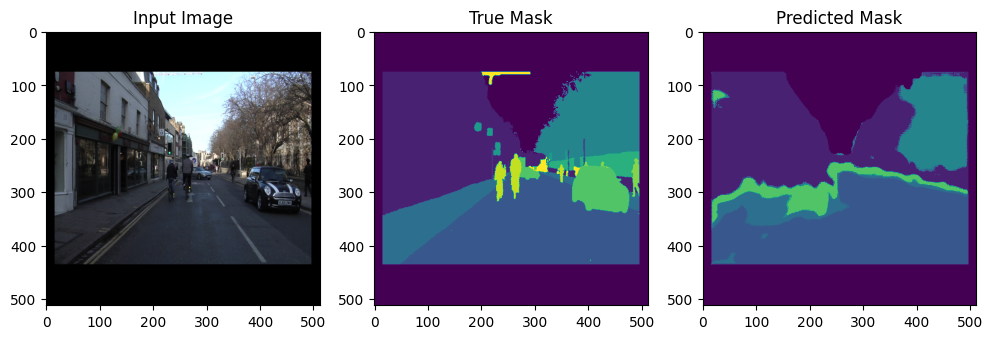

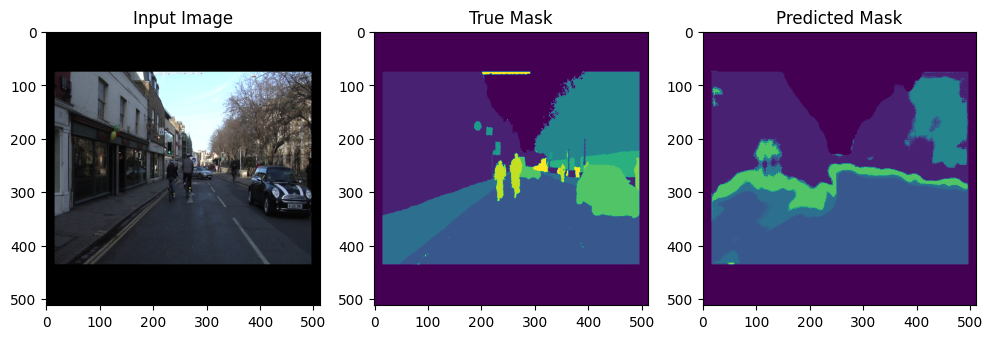

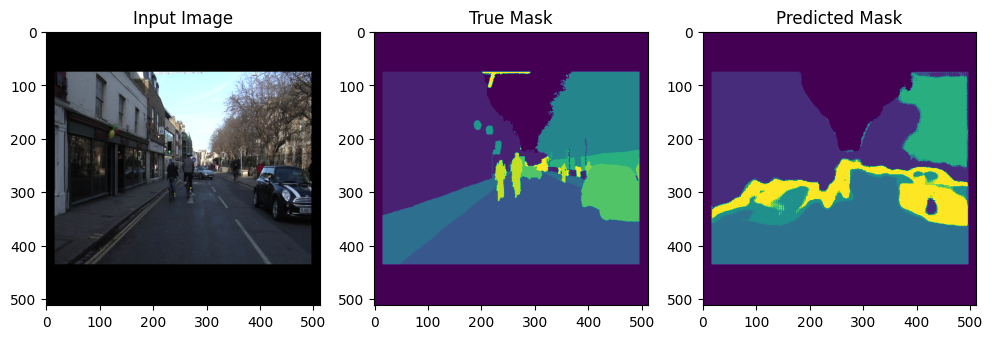

In [147]:
# Evaluate the model on the test dataset
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f'Test Loss: {test_loss}')
# print(f'Test Accuracy: {test_accuracy}')

# Predict the segmentation masks for the test images
predictions = model.predict(test_dataset)

# Function to display the results
def display_results(images, masks, predictions, num_to_display=5):
    for i in range(num_to_display):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(images[i])

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(np.argmax(masks[i], axis=-1))

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.argmax(predictions[i], axis=-1))

        plt.show()

# Display results for a few test images
display_results(test_images, test_masks, predictions)

## Model 2 : Mask RCNN

In [160]:
import detectron2
import random
import cv2
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode


In [125]:
dataset_dir = './cityscapes'
train_json = os.path.join(dataset_dir, "train.json")
val_json = os.path.join(dataset_dir, "val.json")
test_json = os.path.join(dataset_dir, "test.json")
images_dir = os.path.join(dataset_dir, "images")

In [128]:
register_coco_instances("cityscapes_train_3", {}, train_json, images_dir)
register_coco_instances("cityscapes_val_3", {}, val_json, images_dir)
register_coco_instances("cityscapes_test_3", {}, test_json, images_dir)

In [164]:
def setup_cfg():
    cfg = get_cfg()
    cfg.merge_from_file(detectron2.model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("cityscapes_train_3",)
    cfg.DATASETS.TEST = ("cityscapes_val_3",)  # Use validation set for evaluation during training
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = detectron2.model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # Pick a good LR
    cfg.SOLVER.MAX_ITER = 36000   # Set number of iterations for approximately 12 epochs
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # Faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 19  # Number of classes in the Cityscapes dataset (excluding 'unlabeled')

    cfg.OUTPUT_DIR = "./output"
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg

In [ ]:
cfg = setup_cfg()
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg = setup_cfg()
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
cfg = setup_cfg()
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

In [156]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to the trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set a custom testing threshold
predictor = DefaultPredictor(cfg)

# dataset_dicts = DatasetCatalog.get("cityscapes_test_3")
# random_img = random.choice(dataset_dicts)
img = cv2.imread('./jalan3.jpg')

# Make predictions
outputs = predictor(img)

# Visualize the predictions
v = Visualizer(img[:, :, ::-1],
               metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]),
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # Remove the colors of unsegmented pixels
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imshow("Predictions", out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

[08/05 03:29:17 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


In [165]:
register_coco_instances("cityscapes_test_final", {}, test_json, images_dir)

In [ ]:
evaluator = COCOEvaluator('cityscapes_test_final', cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, 'cityscapes_test_final')

print(inference_on_dataset(trainer.model, val_loader, evaluator))

In [157]:
trainer.checkpointer.save("model_final_rcnn")

In [ ]:
from detectron2.data import DatasetCatalog
from detectron2.engine import DefaultPredictor

def generate_predictions(cfg, dataset_name, num_images=500):
    predictor = DefaultPredictor(cfg)
    dataset_dicts = DatasetCatalog.get(dataset_name)
    
    # Limit the dataset to the first num_images images
    limited_dataset = dataset_dicts[:num_images]
    
    predictions = []
    for d in limited_dataset:
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")

        for i in range(len(instances)):
            pred = {}
            pred["image_id"] = d["image_id"]
            pred["category_id"] = int(instances.pred_classes[i])
            pred["bbox"] = instances.pred_boxes[i].tensor.numpy().tolist()[0]
            pred["score"] = float(instances.scores[i])
            pred["segmentation"] = instances.pred_masks[i].numpy().tolist()
            predictions.append(pred)

    return predictions


In [ ]:
cfg = setup_cfg()
predictions = generate_predictions(cfg, 'cityscapes_test_final', num_images=500)
save_predictions(predictions, "./output/predictions.json")

In [ ]:
from pycocotools.coco import COCO

def load_annotations(annotation_file):
    coco = COCO(annotation_file)
    return coco


In [ ]:
from pycocotools.cocoeval import COCOeval

def evaluate_predictions(annotation_file, prediction_file):
    coco = load_annotations(annotation_file)
    coco_dt = coco.loadRes(prediction_file)
    
    coco_eval = COCOeval(coco, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Optionally, evaluate segmentation as well
    coco_eval = COCOeval(coco, coco_dt, "segm")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# Assuming annotations and predictions are saved as JSON files
evaluate_predictions("path/to/cityscapes_test_3/annotations.json", "./output/predictions.json")